<h1 align="center"> Catalog Uplift Modeling – Project Workflow</h1>

---

####  1. Problem Statement

####  2. Data Collection & Data Exploration

####  3. Simple Exploratory Data Analysis (EDA)

####  4. Feature Engineering

####  5. Model Selection

####  6. Model Evaluation

####  7. Deployment

### 1.Problem Statement

Develop a data-driven targeting approach for catalog marketing that:
- Identifies customers who are truly incremental purchasers as a result of receiving a catalog, rather than purchasers who would have bought anyway.
- Estimates the size of this incremental audience and produces a ranked list of customers prioritized by expected incremental lift.
- Focuses on customers who need a catalog to purchase incrementally, explicitly distinguishing them from customers whose purchases merely coincide with catalog sends.


## 2.Data Collection.
We collected DM (customer master) and transaction data from the SSMS server and ingested them into the Lakehouse via the **kartheek_pipeline.** We then began data exploration to understand the spread of the data (distributions, ranges, counts, and outliers) across key fields before further modeling.

## Data Exploration (DM Data)
| Column Name            | Description |
|------------------------|-------------|
| Cust_ID                | Unique identifier for the customer in the system. |
| Src_Sys_Nm             | Source system name from which the customer record originates (e.g., MCD). |
| Gold_Cust_ID           | Master or consolidated customer ID after deduplication. |
| Cust_Combine_Id        | Combined key with source prefix and customer ID for uniqueness. |
| Zip5                   | 5-digit ZIP code of the customer's address. |
| nt_call_ct             | Count of "NT" (possibly non-transactional) calls made to the customer. |
| rtl_call_rec           | Indicates whether retail calls were recorded (Y/N). |
| business_ind           | Indicator showing if the customer is a business account (e.g., RB2B). |
| customer_type          | Classification of the customer type (e.g., RB2B = Retail B2B). |
| tradearea_store        | Trade area store associated with the customer. |
| tradearea_store_dist   | Distance from customer's location to the trade area store. |
| Advantage              | Flag indicating participation in the "Advantage" program (Y/N). |
| MP_GAN                 | Marketing Program Global Account Number — links to campaign targeting. |
| Mailed_Date            | Date the marketing material or offer was mailed to the customer. |
| MPMAIL_IND             | Indicator if the customer was mailed (blank, 1, or 0). |
| MP_MKY                 | Marketing Program key — campaign identifier. |
| MP_CAT                 | Marketing program category code. |
| Managed                | Indicates if the customer is under managed account handling (Y/N). |
| MP_CAT_TYPE            | Description of marketing program category (e.g., Advantage). |
| Group_Flag             | Grouping flag used for campaign segmentation (e.g., Mailed). |
| Post_Sales             | Sales amount after the campaign mailing. |
| Post_Margin            | Margin amount after the campaign mailing. |
| Post_Units             | Units purchased after the campaign mailing. |
| Post_Transactions      | Number of transactions after the campaign mailing. |
| row_num                | Row sequence number (useful for deduplication logic). |
| PreDM_Sales            | Sales amount before the Direct Marketing (DM) campaign. |
| PreDM_Margin           | Margin amount before the DM campaign. |
| PreDM_Units            | Units purchased before the DM campaign. |
| PreDM_Transactions     | Number of transactions before the DM campaign. |





### Column Descriptions (Sales & Transaction)
| Column Name            | Description |
|------------------------|-------------|
| Gold_Cust_ID           | Unique customer ID used across systems. |
| Tran_Id                | Unique transaction identifier. |
| tran_dt                | Date of transaction (format: DD-MM-YYYY). |
| Item_Sk                | Item SKU (Stock Keeping Unit) or product code. |
| Sle_Qty                | Quantity sold in the transaction. |
| checkout_sales         | Final sales amount paid at checkout. |
| Product_Margin         | Gross profit margin on product (before logistics, shipping, etc.). |
| Landed_Margin          | Net profit including shipping and handling costs. |
| quantity               | Units of product purchased (may match `Sle_Qty`). |
| Prc_Gross_Amt          | Gross price before any discounts. |
| Prc_Offer_Amt          | Discounted offer price (if applicable). |
| Prc_CheckOut_Amt       | Actual price paid by the customer. |
| Dir_Ord_Chan_Nm        | Order channel name (e.g., online, retail). |
| OnlineStore_Cd         | Online store code or ID. |
| SameDayCancel_flg      | Flag if the order was cancelled on the same day (1 = Yes, 0 = No). |
| Quote_Release_Dt_SK    | Quote release date surrogate key (if any). |
| BOPIS_Flg              | Buy Online, Pick-up In Store flag (1 = Yes). |
| Cust_Addr_Available_Flg| Flag indicating if customer address is available. |
| Brand                  | Brand name of the product. |
| Subclass               | Product subcategory. |
| vendor_nm              | Name of the vendor or manufacturer. |
| standard_cost          | Standard procurement cost to the company. |
| class                  | Product category (e.g., warranty plans, electronics). |
| class_code             | Numeric/class code for the product category. |
| subclass_code          | Numeric/subclass code for the subcategory. |


## Installing All The Requirements

In [ ]:
%pip install imbalanced-learn

In [ ]:
 # --- Import all packages required---
import re
import os
import math
import warnings
import logging
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline as SparkPipeline
from pyspark.sql.functions import col, when, ntile
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from flaml.automl.spark.utils import to_pandas_on_spark
import mlflow
from mlflow.tracking import MlflowClient
import flaml
from flaml import AutoML

## Data Loading (Catalog Data)

In [ ]:
# Load the data from the specified table in the catalog into a Spark DataFrame
df_dm = spark.sql("SELECT * FROM Kartheek_Pipeline.Catalog_Data")

# Display the DataFrame in a tabular view for quick inspection
display(df_dm)

# Get the list of column names in the DataFrame
df_dm.columns


### Code Explanation
This code reads the **Catalog_Data** table into Spark, shows the data for review, and lists all its column names for reference.

## Data Loading (Sales)

In [ ]:
# Parameters Setup

# Name of the database table containing all customers' sales data
db_sales = "Kartheek_Pipeline.sales_allcustomers"

# Get today's date in YYYYMMDD format to append to table names (ensures unique table names each day)
today_str = datetime.today().strftime('%Y%m%d')

# Name for the scored output table (stores predicted propensity scores)
scored_table_name = f"salesData.Scored_Propensity_{today_str}"

# Name for the clustered output table (stores clustered customer segments)
clustered_table_name = f"salesData.ScoredClusteredAudience_{today_str}"


# -------------------------------------
# Load Sales Data

# Read the sales data from the specified database table into a Spark DataFrame
df_sales = spark.sql(f"SELECT * FROM {db_sales}")

# Display the loaded DataFrame in the notebook for inspection
display(df_sales)

# Retrieve and display the list of column names from the sales DataFrame
df_sales.columns



### Code Explanation
- **db_sales**: Points to your sales data source table in your Databricks/Fabric catalog.  
- **today_str**: Adds a timestamp to output tables so each day's run produces separate tables without overwriting.  
- **scored_table_name** & **clustered_table_name**: Used later to save results of your ML scoring and clustering steps.  
- **spark.sql(...)**: Runs a SQL query against your Spark SQL catalog to load data.  
- **display(df_sales)**: Shows the first few rows in a table-like format for quick visual verification.  
- **df_sales.columns**: Returns all column names, helpful for checking schema before further processing.  


### Join The Both df_dm And df_sales

In [ ]:
# Join DM universe with Sales (keep all customers from df_dm)

# Perform a LEFT JOIN between DM dataset (df_dm) and Sales dataset (df_sales)
# Matching rows on "Gold_Cust_ID"
# The LEFT join ensures all customers from df_dm are retained, even if they have no sales records
df_joined = df_dm.join(df_sales, on="Gold_Cust_ID", how="left")

# --------------------------
# Compute Days from Mail
# Add a new column "Days_From_Mail" that calculates the difference in days
# between transaction date ("Tran_Dt") and mailed date ("Mailed_Date")
df_valid = df_joined.withColumn("Days_From_Mail", F.datediff("Tran_Dt", "Mailed_Date"))

### Code Explanation
- **df_dm.join(df_sales, on="Gold_Cust_ID", how="left")**:  
  Performs a **LEFT JOIN** between the DM universe (`df_dm`) and Sales data (`df_sales`) on the `Gold_Cust_ID` column.  
  This ensures all customers from the DM universe are kept, even if they have no matching sales record.

- **F.datediff("Tran_Dt", "Mailed_Date")**:  
  Calculates the number of days between the transaction date (`Tran_Dt`) and the mailing date (`Mailed_Date`).

- **withColumn("Days_From_Mail", ...)**:  
  Adds a new column named `Days_From_Mail` to the DataFrame, storing the computed day differences.


####  3. Simple Exploratory Data Analysis (EDA)

In [ ]:
from pyspark.sql import functions as F

def simple_eda(df):
    # 1. Shape info
    print("=== Shape ===")
    print(f"Rows: {df.count()}, Columns: {len(df.columns)}\n")
    
    # 2. Schema & data types
    print("=== Schema & Data Types ===")
    df.printSchema()
    print()
    
    # 3. Null counts per column
    print("=== Null Counts per Column ===")
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
    null_counts.show(vertical=True)
    
    # 4. Distinct counts per column
    print("=== Distinct Counts per Column ===")
    distinct_counts = df.select([F.countDistinct(c).alias(c) for c in df.columns])
    distinct_counts.show(vertical=True)
    
    # 5. Quick sample
    print("=== Sample Data ===")
    df.show(5, truncate=False)

# Return the Function 
simple_eda(df_valid)


### Code Explanation 

#### 1. Shape Information
- Shows how many **rows** and **columns** you have.
- `df.count()` triggers a **full scan**, so on massive datasets it can take time.
- Number of columns is fast to compute using `len(df.columns)`.

#### 2. Schema & Data Types
- Useful for checking if Spark has **inferred the correct data types**.
- Helps you spot issues like **numbers stored as strings**.

#### 3. Null Counts
- Quickly tells you how many **missing values** are in each column.
- Helps you decide if you need **imputation**, **dropping columns**, or other preprocessing steps.

#### 4. Distinct Counts
- Shows how many **unique values** each column has.
- Helps detect:
  - **Categorical features** (low distinct count)
  - **Continuous features** (high distinct count)
  - **Unique identifiers** (distinct count ≈ row count)

#### 5. Sample Data
- Lets you visually inspect a few records to understand **structure and content**.
- Helps verify if the data loaded correctly and matches expectations.


In [ ]:
print(df_valid.columns)
num_customers = df_valid.select("Gold_Cust_ID").distinct().count()
print(f" Number of distinct customers in df_scored: {num_customers}")


### Code Explanation

1. `print(df_valid.columns)`  
   - Prints all column names in the DataFrame `df_valid` as a Python list.  
   - Useful for quickly checking available fields.

2. `df_valid.select("Gold_Cust_ID")`  
   - Selects only the `Gold_Cust_ID` column from `df_valid`.

3. `.distinct()`  
   - Removes duplicate `Gold_Cust_ID` values, keeping only unique customer IDs.

4. `.count()`  
   - Counts the number of unique customers.

5. `num_customers = ...`  
   - Stores the count of unique customers in the variable `num_customers`.

6. `print(f" Number of distinct customers in df_scored: {num_customers}")`  
   - Prints the count of unique customers with a descriptive message.


In [2]:
# # Save df_valid as a managed table
df_valid.write.mode("overwrite").saveAsTable("Kartheek_Pipeline.Catalog_Universe_with_Sales")


StatementMeta(, 83d9e1bd-dcb0-48bb-abc2-6fba7b828887, 4, Finished, Available, Finished)

### Code Explanation
- **Purpose:** Saves the DataFrame `df_valid` as a **managed Delta table** in the metastore.  
- **`write.mode("overwrite")`** → Overwrites the table if it already exists.  
- **`saveAsTable("Kartheek_Pipeline.Catalog_Universe_with_Sales")`** → Creates or replaces a managed table with the given name in the `Kartheek_Pipeline` schema.


## Feature Engineering – Catalog Segmentation

## Creating the tables For B2C (Catalog Consumers)

In [6]:
# Query the Spark SQL table and load all rows/columns into a DataFrame
df = spark.sql("SELECT * FROM Kartheek_Pipeline.catalog_universe_with_sales")

# Display the DataFrame
display(df)

StatementMeta(, 83d9e1bd-dcb0-48bb-abc2-6fba7b828887, 8, Finished, Available, Finished)

### Code Explanation
1. `df = spark.sql("SELECT * FROM Kartheek_Pipeline.catalog_universe_with_sales")`  
   - Runs a Spark SQL query to select all records from the `Kartheek_Pipeline.catalog_universe_with_sales` table.  
   - Loads the result into a DataFrame called `df`.

In [1]:
# Filtering the Cons Column 
from pyspark.sql.functions import col, lower
df_cat = df.filter(col("MP_CAT_TYPE") == "catalog")
df_cons = df_cat.filter(lower(col("customer_type")) == "cons")
display(df_cons)


StatementMeta(, fc527cc8-b8ac-4ea3-b4b3-9de3bce6992e, 3, Finished, Available, Finished)

### Code Explanation – Filtering Consumers from Sales Universe Data
- First, the data is filtered to include only records where the mailing type is **Catalog**.  
- Then, from this subset, only **consumer (B2C)** customers are selected based on the `customer_type` column.  
- The result is a dataset containing only catalog records for consumer customers.


In [ ]:
from pyspark.sql import functions as F

# Group the DataFrame by customer, transaction, and mailing-related columns
grouped_df = df.groupBy(
    "Gold_Cust_ID", "Cust_ID", "Src_Sys_Nm", "Cust_Combine_Id", "Zip5",
    "nt_call_ct", "rtl_call_rec", "business_ind", "customer_type",
    "tradearea_store", "tradearea_store_dist", "Advantage", "MP_GAN",
    "Mailed_Date", "MPMAIL_IND", "MP_MKY", "MP_CAT", "Managed",
    "MP_CAT_TYPE", "Group_Flag", "Post_Sales", "Post_Margin",
    "Post_Units", "Post_Transactions", "row_num",
    "PreDM_Sales", "PreDM_Margin", "PreDM_Units", "PreDM_Transactions"
).agg(
    # Sum of numeric metrics
    F.sum("Sle_Qty").alias("Total_Sle_Qty"),                     # Total sales quantity
    F.sum("checkout_sales").alias("Total_Checkout_Sales"),       # Total checkout sales
    F.sum("Product_Margin").alias("Total_Product_Margin"),       # Total product margin
    F.sum("Landed_Margin").alias("Total_Landed_Margin"),         # Total landed margin
    F.sum("quantity").alias("Total_Quantity"),                   # Total quantity sold

    # Average of price-related fields
    F.avg("Prc_Gross_Amt").alias("Avg_Prc_Gross_Amt"),            # Average gross price
    F.avg("Prc_Offer_Amt").alias("Avg_Prc_Offer_Amt"),            # Average offer price
    F.avg("Prc_CheckOut_Amt").alias("Avg_Prc_CheckOut_Amt"),      # Average checkout price

    # Distinct counts
    F.countDistinct("Dir_Ord_Chan_Nm").alias("Distinct_Channels"),# Number of unique order channels

    # Unique value collections
    F.collect_set("Brand").alias("Unique_Brands"),                # Set of unique brands purchased
    F.collect_set("Subclass").alias("Unique_Subclasses"),         # Set of unique subclasses
    F.collect_set("vendor_nm").alias("Vendors"),                  # Set of unique vendors

    # Average cost
    F.avg("standard_cost").alias("Avg_Standard_Cost"),            # Average standard cost

    # First value pick (non-null)
    F.first("OnlineStore_Cd").alias("First_OnlineStore_Cd"),      # First online store code
    F.first("SameDayCancel_flg").alias("First_SameDayCancel_flg"),# First same-day cancel flag
    F.first("Quote_Release_Dt_SK").alias("First_QuoteReleaseDt"), # First quote release date
    F.first("BOPIS_Flg").alias("First_BOPIS_Flg"),                 # First BOPIS flag
    F.first("Cust_Addr_Available_Flg").alias("First_Cust_Addr_Avail") # First customer address available flag
)


### Code Explanation – Grouping and Aggregation
- **Purpose:** Summarize transaction and customer data by grouping on customer, store, and mailing-related fields.
- **Aggregations performed:**
  - **Sum:** Calculates total sales quantities, checkout sales, product margins, landed margins, and total quantity.
  - **Average:** Computes average prices (gross, offer, checkout) and average standard cost.
  - **Distinct Count:** Counts unique order channels per group.
  - **Collect Set:** Gathers unique brands, subclasses, and vendors into lists.
  - **First Value:** Picks the first recorded value for certain flags or codes.
- **Output:** A condensed DataFrame where each row represents one group with aggregated metrics and unique value sets.


In [ ]:
from pyspark.sql.functions import (
    to_date, col, datediff, mean, stddev, countDistinct, sum, max, first
)

# 1. Ensure date formats
df_cons = df_cons.withColumn("tran_dt", to_date("tran_dt", "dd-MM-yyyy"))
df_cons = df_cons.withColumn("Mailed_Date", to_date("Mailed_Date", "dd-MM-yyyy"))

# 2. Filter only transactions that occurred BEFORE the mail date
df_pre_mail = df_cons.filter(col("tran_dt") < col("Mailed_Date"))

# 3. Aggregate RFM features per customer
rfm_df = df_pre_mail.groupBy("Gold_Cust_ID").agg(
    max("tran_dt").alias("last_transaction_date"),
    countDistinct("Tran_Id").alias("Frequency"),
    sum("checkout_sales").alias("Monetary"),
    first("Mailed_Date").alias("Mailed_Date")  # Reference point for Recency
)

# 4. Compute Recency in days (Mail_Date - Last_Transaction)
rfm_df = rfm_df.withColumn("Recency", datediff(col("Mailed_Date"), col("last_transaction_date")))

# 5. Compute mean and stddev for each RFM column
stats = rfm_df.select(
    mean("Recency").alias("mean_rec"),
    stddev("Recency").alias("std_rec"),
    mean("Frequency").alias("mean_freq"),
    stddev("Frequency").alias("std_freq"),
    mean("Monetary").alias("mean_mon"),
    stddev("Monetary").alias("std_mon")
).collect()[0]

# 6. Broadcast stats
mean_rec, std_rec = stats["mean_rec"], stats["std_rec"]
mean_freq, std_freq = stats["mean_freq"], stats["std_freq"]
mean_mon, std_mon = stats["mean_mon"], stats["std_mon"]

# 7. Add standardized z-scores
rfm_df = rfm_df \
    .withColumn("Recency_Z", (mean_rec - col("Recency")) / std_rec) \
    .withColumn("Frequency_Z", (col("Frequency") - mean_freq) / std_freq) \
    .withColumn("Monetary_Z", (col("Monetary") - mean_mon) / std_mon) \
    .withColumn("RFM_Z_Composite", col("Recency_Z") + col("Frequency_Z") + col("Monetary_Z"))

# 8. (Optional) View sample
rfm_df.select("Gold_Cust_ID", "Recency", "Frequency", "Monetary", 
              "Recency_Z", "Frequency_Z", "Monetary_Z", "RFM_Z_Composite").show(10)


### Code Explanation – RFM Analysis

1. **Convert Dates**  
   - Ensure `tran_dt` and `Mailed_Date` are in proper date format.

2. **Filter Pre-Mail Transactions**  
   - Keep only transactions that happened **before** the mail date.

3. **Aggregate RFM Features**  
   - For each customer:
     - `last_transaction_date` → Most recent transaction date before mail.  
     - `Frequency` → Number of distinct transactions.  
     - `Monetary` → Total sales before mail.  
     - `Mailed_Date` → Reference date for recency calculation.

4. **Calculate Recency**  
   - Days between mail date and last transaction.

5. **Compute Stats**  
   - Get mean and standard deviation for Recency, Frequency, and Monetary.

6. **Standardize (Z-Scores)**  
   - Create normalized scores for each RFM metric.  
   - Combine them into `RFM_Z_Composite` for an overall score.

7. **View Sample Output**  
   - Show first 10 customers with raw and standardized RFM metrics.


In [ ]:
# final_df will have all features + RFM z-scores
final_df = grouped_df.join(
    rfm_df.select("Gold_Cust_ID", "Recency", "Frequency", "Monetary",
                  "Recency_Z", "Frequency_Z", "Monetary_Z", "RFM_Z_Composite"),
    on="Gold_Cust_ID",
    how="left"
)


### Code Explanation - Joining RFM Scores to Main Dataset

- **Purpose**:  
  Add RFM metrics (`Recency`, `Frequency`, `Monetary`) and their standardized z-scores to the main customer dataset.

- **Logic**:  
  - Match records from `grouped_df` with `rfm_df` using `Gold_Cust_ID`.
  - Keep all rows from `grouped_df` (left join).
  - Bring over only the required RFM columns from `rfm_df`.

- **Result**:  
  `final_df` now contains both:
    1. Original features from `grouped_df`.
    2. RFM-related numeric features for modeling or segmentation.


In [ ]:
from pyspark.sql.functions import col, sqrt, pow, lit, when

# Step 1: Normalize Pre and Post features
final_df = final_df.withColumns({
    "PreDM_Sales_Rate": col("PreDM_Sales") / 90,
    "PreDM_Margin_Rate": col("PreDM_Margin") / 90,
    "PreDM_Units_Rate": col("PreDM_Units") / 90,
    "PreDM_Transactions_Rate": col("PreDM_Transactions") / 90,

    "Post_Sales_Rate": col("Post_Sales") / 30,
    "Post_Margin_Rate": col("Post_Margin") / 30,
    "Post_Units_Rate": col("Post_Units") / 30,
    "Post_Transactions_Rate": col("Post_Transactions") / 30
})

# Step 2: Add SpendRate_Z and Response Flag
epsilon = 1e-6

final_df = final_df.withColumn(
    "SpendRate_Z", 
    (col("Post_Sales_Rate") - col("PreDM_Sales_Rate")) /
    sqrt(pow(col("PreDM_Margin_Rate"), 2) + pow(col("Post_Margin_Rate"), 2) + lit(epsilon))
).withColumn(
    "response_flag", 
    when((col("SpendRate_Z") > 1.645) & (col("Group_Flag") == "Mailed"), 1).otherwise(0)
)

### Step 1: Normalize Pre and Post Campaign Metrics
- Creates **rate features** for both:
  - **Pre-campaign** (90 days)
  - **Post-campaign** (30 days)
- Instead of using raw totals (e.g., total sales),  
  calculates **daily averages** by dividing totals by the number of days in each period.
- This makes metrics **comparable** across periods, even if their time windows differ.

### Step 2: Calculate `SpendRate_Z` and Response Flag
- **SpendRate_Z**:
  - Measures how much the **post-campaign sales rate** differs from the **pre-campaign sales rate**.
  - Adjusted for variability in margins (standard deviation).
  - Higher values = greater positive change in spending after the campaign.
  
- **response_flag**:
  - Binary indicator of campaign influence.
  - **1** → Customer had a significant positive change (`SpendRate_Z > 1.645`) **and** was part of the "Mailed" group.
  - **0** → Otherwise.
- Essentially flags customers **likely influenced** by the campaign.


## Catalog B2C Created on Functions

In [13]:
def load_b2c():
    """Load and cache the B2C Delta table."""
    df = spark.read.format("delta").load("Tables/b2c_circulation_input_15pctz").cache()
    return df

StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 15, Finished, Available, Finished)

### Code Explanation
- **spark.read.format("delta")**: Specifies that the data source format is **Delta Lake**.  
- **.load("Tables/b2c_circulation_input_15pctz")**: Loads the Delta table from the given table path.  
- **.cache()**: Caches the DataFrame in memory for faster repeated access during the pipeline.  
- **return df**: Returns the loaded and cached DataFrame so it can be used in further processing steps.  


In [14]:
def eda_and_balance(df, target_col):
    import matplotlib.pyplot as plt
    from pyspark.sql import functions as F

    print("[INFO] First 10 rows of the input DataFrame before any processing:")
    display(df.limit(10))
    print("Checking class balance in target column...")

    distribution = (
        df.groupBy(target_col)
          .agg(F.count("*").alias("count"))
          .withColumn("proportion", F.col("count") / df.count())
    )
    distribution_pd = distribution.toPandas()
    distribution_pd = distribution_pd.set_index(target_col)['proportion']
    dominant_class_proportion = distribution_pd.max()
    distribution_pd.plot(kind='bar')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.show()

    if dominant_class_proportion > 0.8:
        print(f"The dataset is imbalanced. The dominant class has {dominant_class_proportion * 100:.2f}% of the samples.")
        print("You may need to handle class imbalance before training the model.")
    else:
        print("The dataset is balanced.")
    return


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 16, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Performs basic **Exploratory Data Analysis (EDA)** on the target column to check for **class imbalance** and visualize it.

- **import matplotlib.pyplot as plt**: Imports Matplotlib for plotting graphs.  
- **from pyspark.sql import functions as F**: Imports PySpark SQL functions for aggregation and column operations.

- **display(df.limit(10))**: Displays the first 10 rows of the DataFrame for a quick look at the data before any processing.

- **df.groupBy(target_col).agg(F.count("*").alias("count"))**: Groups the data by the target column and counts the number of samples in each class.  
- **.withColumn("proportion", F.col("count") / df.count())**: Adds a new column showing the proportion of each class.  

- **distribution.toPandas()**: Converts the Spark DataFrame to a Pandas DataFrame for plotting.  
- **distribution_pd.plot(kind='bar')**: Creates a bar chart showing class proportions.  

- **if dominant_class_proportion > 0.8**: Checks if the dataset is **imbalanced** (one class > 80% of the data).  
  - **Prints a warning** if imbalance is detected.  
  - Otherwise, prints that the dataset is balanced.

- **return**: Ends the function without modifying the input DataFrame.


In [15]:
def clean_and_split(df, target_col):
    import re
    from pyspark.sql.functions import col

    # Clean column names
    df = df.toDF(*(re.sub('[^A-Za-z0-9_]+', '_', c) for c in df.columns))
    # Drop columns that are entirely null
    non_null_columns = [c for c in df.columns if df.filter(col(c).isNotNull()).count() > 0]
    df = df.select(*non_null_columns)
    # Split into train/test
    train_raw, test_raw = df.randomSplit([0.8, 0.2], seed=42)
    return df, train_raw, test_raw


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 17, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Cleans the input DataFrame's column names, removes empty columns, and splits the data into training and testing sets.

- **import re**: Imports the regex module for string pattern matching and replacement.  
- **from pyspark.sql.functions import col**: Imports `col` for referencing columns in PySpark transformations.

- **df.toDF(*(re.sub('[^A-Za-z0-9_]+', '_', c) for c in df.columns))**:  
  - Iterates through each column name and replaces all non-alphanumeric characters with underscores (`_`).  
  - Creates a clean set of column names compatible with Spark operations.

- **non_null_columns = [c for c in df.columns if df.filter(col(c).isNotNull()).count() > 0]**:  
  - Loops through all columns and keeps only those that have at least one non-null value.  

- **df.select(*non_null_columns)**: Selects only the columns that are not entirely null.

- **train_raw, test_raw = df.randomSplit([0.8, 0.2], seed=42)**:  
  - Randomly splits the dataset into 80% training and 20% testing sets.  
  - Uses a fixed seed (`42`) to ensure reproducibility.

- **return df, train_raw, test_raw**:  
  - Returns the cleaned DataFrame, along with the training and testing subsets.


In [16]:
def preprocess_and_impute(train_raw, test_raw):
    from pyspark.ml import Pipeline as SparkPipeline

    # Place-holder pipeline (can be extended)
    pipeline_obj = SparkPipeline(stages=[])
    model = pipeline_obj.fit(train_raw)
    train_raw = model.transform(train_raw)
    test_raw = model.transform(test_raw)
    # Impute/fill missing values in all columns with 0
    train_raw = train_raw.fillna(0)
    test_raw  = test_raw.fillna(0)
    return train_raw, test_raw


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 18, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Prepares the training and testing DataFrames by running them through a placeholder Spark ML pipeline and imputing missing values.

- **from pyspark.ml import Pipeline as SparkPipeline**: Imports Spark's `Pipeline` class for structuring data processing steps.

- **pipeline_obj = SparkPipeline(stages=[])**:  
  - Creates an empty Spark ML pipeline (no stages yet).  
  - Acts as a placeholder so that additional preprocessing steps (e.g., feature encoding, scaling) can be added later.

- **model = pipeline_obj.fit(train_raw)**: Fits the empty pipeline to the training data.  
- **train_raw = model.transform(train_raw)**: Applies the fitted pipeline to the training set.  
- **test_raw = model.transform(test_raw)**: Applies the same fitted pipeline to the test set.

- **train_raw.fillna(0)** / **test_raw.fillna(0)**:  
  - Replaces all `null` or missing values in every column with `0` in both datasets.  
  - Ensures there are no null values before model training.

- **return train_raw, test_raw**: Returns the processed and imputed training and test DataFrames.


In [17]:
def select_and_vectorize(df, train_raw, test_raw, target_col):
    from pyspark.sql.types import FloatType, DoubleType, ShortType, IntegerType, LongType
    from pyspark.ml.feature import VectorAssembler

    def filter_supported_columns(df, feature_cols):
        supported_types = (FloatType, DoubleType, ShortType, IntegerType, LongType)
        return [col_name for col_name in feature_cols if isinstance(df.schema[col_name].dataType, supported_types)]
    feature_cols = [c for c in df.columns if c != target_col]
    feature_cols = filter_supported_columns(df, feature_cols)
    print("Vectorizing features...")
    featurizer = VectorAssembler(
        inputCols=feature_cols, outputCol="features", handleInvalid="keep"
    )
    train_data = featurizer.transform(train_raw).select(target_col, "features")
    test_data  = featurizer.transform(test_raw).select(target_col, "features")
    return featurizer, feature_cols, train_data, test_data


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 19, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Selects numeric feature columns and combines them into a single `features` vector for Spark ML model training.

- **from pyspark.sql.types import ...**: Imports numeric Spark data types to filter for supported feature columns.  
- **from pyspark.ml.feature import VectorAssembler**: Imports Spark's `VectorAssembler`, which merges multiple columns into a single vector column.

- **filter_supported_columns(df, feature_cols)**:  
  - Helper function that keeps only columns whose data types are numeric (`FloatType`, `DoubleType`, `ShortType`, `IntegerType`, `LongType`).  
  - Ensures only numeric features are included for model training.

- **feature_cols = [c for c in df.columns if c != target_col]**:  
  - Selects all columns except the target column.  

- **feature_cols = filter_supported_columns(df, feature_cols)**:  
  - Filters the feature list to include only numeric columns.

- **VectorAssembler(...)**:  
  - Combines all numeric feature columns into a single vector column named `"features"`.  
  - **handleInvalid="keep"** ensures that invalid data (e.g., NaNs) is preserved rather than causing an error.

- **featurizer.transform(train_raw).select(target_col, "features")**:  
  - Transforms the training data into the format required by Spark ML, keeping only the target and feature vector columns.  

- **featurizer.transform(test_raw).select(target_col, "features")**:  
  - Applies the same transformation to the test data.

- **return featurizer, feature_cols, train_data, test_data**:  
  - Returns the fitted `VectorAssembler`, the list of feature columns used, and the transformed train/test DataFrames.


In [18]:
def upsample(train_data, target_col):
    from pyspark.sql.functions import col
    print("Balancing classes in training set with upsampling positive class...")
    pos = train_data.filter(col(target_col) == 1)
    neg = train_data.filter(col(target_col) == 0)
    n_pos = pos.count()
    n_neg = neg.count()
    ratio = float(n_neg) / n_pos if n_pos > 0 else 1.0
    pos_upsampled = pos.sample(withReplacement=True, fraction=ratio, seed=42)
    train_data_bal = neg.union(pos_upsampled)
    return train_data_bal


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 20, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Balances the training dataset by **upsampling** the minority class (positive class) so that both classes have similar representation for model training.

- **from pyspark.sql.functions import col**: Imports `col` to reference columns in PySpark filters.

- **pos = train_data.filter(col(target_col) == 1)**: Selects all rows belonging to the **positive class** (label `1`).  
- **neg = train_data.filter(col(target_col) == 0)**: Selects all rows belonging to the **negative class** (label `0`).

- **n_pos = pos.count() / n_neg = neg.count()**: Counts the number of samples in each class.  

- **ratio = float(n_neg) / n_pos if n_pos > 0 else 1.0**:  
  - Calculates how many times the positive class needs to be repeated to match the size of the negative class.  
  - If there are no positive samples, defaults to `1.0` (avoids division by zero).

- **pos.sample(withReplacement=True, fraction=ratio, seed=42)**:  
  - Randomly samples positive-class rows **with replacement** until their count is approximately equal to the negative class.  
  - `fraction=ratio` controls how many times to replicate the positive samples.  
  - `seed=42` ensures reproducibility.

- **neg.union(pos_upsampled)**: Combines the original negative-class samples with the upsampled positive-class samples.

- **return train_data_bal**: Returns the balanced training DataFrame.


In [19]:
def flaml_training(train_data, test_data, target_col, mode):
    import os, flaml, mlflow
    from flaml import AutoML
    from datetime import datetime
    from flaml.automl.spark.utils import to_pandas_on_spark

    df_train = to_pandas_on_spark(train_data)
    df_test  = to_pandas_on_spark(test_data)

    os.environ["MLFLOW_TRACKING_URI"] = "file:///tmp/mlruns"
    auto_name = datetime.now().strftime(f"AutoMLExperiment_{mode}_%Y%m%d_%H%M%S")
    mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
    mlflow.set_experiment(auto_name)
    mlflow.autolog(exclusive=False)

    settings = {
        "time_budget": 120,
        "task": "binary",
        "log_file_name": f"flaml_experiment_{mode}.log",
        "eval_method": "cv",
        "n_splits": 3,
        "max_iter": 10,
        "force_cancel": True,
        "seed": 41,
        "mlflow_exp_name": auto_name,
        "verbose": 1,
        "featurization": "auto",
    }
    if flaml.__version__ > "2.3.3":
        settings["entrypoint"] = "low-code"

    automl = AutoML(**settings)
    print("Starting FLAML AutoML training...")
    with mlflow.start_run(nested=True, run_name=f"Catalog_gowtham_{mode.upper()}-AutoMLModel"):
        automl.fit(dataframe=df_train, label=target_col)
    return automl, auto_name, df_test


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 21, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Trains an AutoML model using **FLAML** on Spark DataFrames, logs the process to **MLflow**, and prepares the test dataset for later evaluation.

- **Imports**:  
  - **os, flaml, mlflow**: Handles environment settings, AutoML training, and experiment logging.  
  - **AutoML**: FLAML’s main class for automated machine learning.  
  - **datetime**: For generating unique experiment names.  
  - **to_pandas_on_spark**: Converts Spark DataFrames to Pandas-on-Spark DataFrames (FLAML expects Pandas-compatible input).

- **df_train / df_test = to_pandas_on_spark(...)**: Converts training and testing Spark DataFrames into Pandas-on-Spark format for FLAML.

- **os.environ["MLFLOW_TRACKING_URI"]**: Sets the MLflow tracking location (here, a local file path `/tmp/mlruns`).  
- **auto_name = datetime.now().strftime(...)**: Creates a unique experiment name including the mode (`b2c` or `b2b`) and timestamp.  
- **mlflow.set_tracking_uri(...) / mlflow.set_experiment(...)**: Configures MLflow tracking and assigns the experiment name.  
- **mlflow.autolog(exclusive=False)**: Enables automatic logging of parameters, metrics, and models during training.

- **settings = {...}**: Defines FLAML configuration:  
  - `time_budget`: Max seconds for training (120s here).  
  - `task`: `"binary"` classification task.  
  - `eval_method`: Cross-validation (`cv`) with `n_splits=3`.  
  - `max_iter`: Max number of model trials.  
  - `seed`: Ensures reproducibility.  
  - `featurization`: `"auto"` lets FLAML handle preprocessing.  
  - Optional `"entrypoint"` for newer FLAML versions.

- **automl = AutoML(**settings)**: Creates an AutoML object with the given settings.

- **with mlflow.start_run(...)**: Starts an MLflow run and assigns a descriptive run name.  
- **automl.fit(dataframe=df_train, label=target_col)**: Runs FLAML AutoML training on the training data, targeting the specified label.

- **return automl, auto_name, df_test**:  
  - Returns the trained AutoML object, experiment name, and the converted test DataFrame for evaluation.


In [20]:
def register_and_load_model(auto_name, mode):
    import mlflow
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    exp = client.get_experiment_by_name(auto_name)
    exp_id = exp.experiment_id
    best_run = client.search_runs([exp_id], order_by=["metrics.f1_score DESC"], max_results=1)[0]
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"

    # Register
    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=f"Catalog_gowtham{mode.upper()}-AutoMLModel"
    )
    print(f"Registered model '{registered_model.name}' version {registered_model.version}")

    # Load from Registry (more reliable than local runs:/ path)
    registry_uri = f"models:/Catalog_gowtham{mode.upper()}-AutoMLModel/{registered_model.version}"
    try:
        spark_model = mlflow.spark.load_model(registry_uri)
    except Exception:
        # Fallback to pyfunc if Spark flavor is not present
        spark_model = mlflow.pyfunc.load_model(registry_uri)

    print("Loaded model from:", registry_uri)
    return spark_model


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 22, Finished, Available, Finished)

### Code Explanation
- **Function Purpose**: Finds the best AutoML run from MLflow, registers the model in the MLflow Model Registry, and loads it back for inference.

- **from mlflow.tracking import MlflowClient**: Imports the MLflow client API to interact with experiments and runs.

- **client = MlflowClient()**: Creates an MLflow client instance for programmatic access.

- **exp = client.get_experiment_by_name(auto_name)**: Retrieves the MLflow experiment by its name.  
- **exp_id = exp.experiment_id**: Stores the experiment ID for querying runs.  

- **best_run = client.search_runs(...)**:  
  - Searches all runs in the experiment.  
  - Orders them by `f1_score` in descending order (best model first).  
  - Retrieves only the top run (`max_results=1`).  

- **run_id = best_run.info.run_id**: Extracts the unique run ID of the best run.  
- **model_uri = f"runs:/{run_id}/model"**: Constructs the URI pointing to the model artifact in the run.

- **mlflow.register_model(...)**:  
  - Registers the best model in the MLflow Model Registry.  
  - The name includes the `mode` (e.g., `B2C` or `B2B`) for clarity.  

- **registry_uri = f"models:/Catalog_gowtham{mode.upper()}-AutoMLModel/{registered_model.version}"**:  
  - Creates the registry URI to load the specific model version.  

- **spark_model = mlflow.spark.load_model(...)**:  
  - Attempts to load the registered model in **Spark ML** format.  
  - If that fails, falls back to `mlflow.pyfunc.load_model()` for a generic Python model flavor.

- **print(...)**: Logs model registration and loading details for debugging.

- **return spark_model**: Returns the loaded model object ready for predictions.


In [22]:
def evaluate_test_set(spark_model, df_test, target_col):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml.functions import vector_to_array
    from pyspark.sql.functions import col, when
    import pyspark.sql.functions as F

    df_test_spark = df_test.to_spark()
    scored_test = spark_model.transform(df_test_spark)\
        .withColumn("pred_prob", vector_to_array(col("probability"))[1])
    preds = scored_test.withColumn("pred", when(col("pred_prob") >= 0.5, 1).otherwise(0))
    metrics = preds.agg(
        F.sum(when((col(target_col) == 1) & (col("pred") == 1), 1).otherwise(0)).alias("tp"),
        F.sum(when((col(target_col) == 0) & (col("pred") == 1), 1).otherwise(0)).alias("fp"),
        F.sum(when((col(target_col) == 1) & (col("pred") == 0), 1).otherwise(0)).alias("fn"),
        F.sum(when((col(target_col) == 0) & (col("pred") == 0), 1).otherwise(0)).alias("tn")
    ).collect()[0]
    tp, fp, fn, tn = metrics["tp"], metrics["fp"], metrics["fn"], metrics["tn"]
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall   = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1       = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn)>0 else 0.0
    roc_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol=target_col, metricName="areaUnderROC")
    pr_eval  = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol=target_col, metricName="areaUnderPR")
    roc_auc  = roc_eval.evaluate(scored_test)
    pr_auc   = pr_eval.evaluate(scored_test)
    print(f"Threshold=0.50 → Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Accuracy={accuracy:.4f}")
    print(f"ROC AUC={roc_auc:.4f}, PR AUC={pr_auc:.4f}")
    print("Top 10 prediction results (with predicted probabilities and labels):")
    preds.select("pred_prob", "pred").show(10, False)
    return spark_model


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 24, Finished, Available, Finished)

### Code Explanation

This function evaluates a trained Spark ML model on a test dataset and calculates key classification metrics.

## Workflow
1. **Convert Data**  
   Converts test data into a Spark DataFrame format for processing.

2. **Generate Predictions**  
   Uses the trained model to score the test set and extract probabilities for the positive class.

3. **Apply Threshold**  
   Converts predicted probabilities into binary predictions using a fixed threshold (0.5).

4. **Compute Confusion Matrix**  
   Calculates True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN).

5. **Calculate Metrics**  
   - **Precision**: Proportion of predicted positives that are correct.  
   - **Recall**: Proportion of actual positives that are correctly predicted.  
   - **F1 Score**: Harmonic mean of precision and recall.  
   - **Accuracy**: Proportion of correct predictions overall.

6. **Evaluate AUC Scores**  
   - **ROC AUC**: Measures discrimination between classes.  
   - **PR AUC**: Focuses on performance for the positive class, useful for imbalanced datasets.

7. **Display Results**  
   Prints all metrics and displays a sample of predictions with their probabilities.

## Key Notes
- Uses a fixed threshold of 0.5 (can be adjusted for better performance).
- PR AUC is especially valuable when dealing with class imbalance.
- Outputs both numerical metrics and a preview of scored predictions.


In [23]:
def post_scoring_and_segments(df, featurizer, spark_model, target_col, mode):
    import math
    from pyspark.sql.window import Window
    from pyspark.sql.functions import col, when, round
    import pyspark.sql.functions as F
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.functions import vector_to_array
    from pyspark.sql.types import DoubleType

    print("Scoring customers and joining RFM metrics...")

    # 1. Featurize input data
    df_features = featurizer.transform(df)

    # 2. Score the customers
    scored_df = spark_model.transform(df_features) \
        .withColumn("propensity", vector_to_array(col("probability"))[1]) \
        .select("Cust_ID", "propensity", target_col)

    # 3. Bring in RFM score
    rfm_df = df.select("Cust_ID", "RFM_Z_Composite").distinct()
    scored_df = scored_df.join(rfm_df, on="Cust_ID", how="left")

    print("Assigning deciles for propensity and RFM scores...")
    window_propensity = Window.orderBy(col("propensity").desc())
    window_rfm = Window.orderBy(col("RFM_Z_Composite").desc())
    scored_df = scored_df \
        .withColumn("propensity_decile", F.ntile(10).over(window_propensity)) \
        .withColumn("rfm_decile", F.ntile(10).over(window_rfm))

    # 4. Composite score calculation
    propensity_weight = 0.6
    rfm_weight = 0.4
    propensity_power = 1.5
    rfm_power = 1.2
    scored_df = scored_df.withColumn(
        "final_score_nuanced",
        (F.pow(11 - F.col("propensity_decile"), propensity_power) * propensity_weight) +
        (F.pow(11 - F.col("rfm_decile"), rfm_power) * rfm_weight)
    )

    # 5. Decile based on final score
    window_decile = Window.orderBy(col("final_score_nuanced").desc())
    scored_df = scored_df.withColumn("decile", F.ntile(10).over(window_decile))

    # 6. Fix types and fill nulls
    scored_df = scored_df.withColumn("propensity", F.col("propensity").cast(DoubleType())) \
        .withColumn("RFM_Z_Composite", F.col("RFM_Z_Composite").cast(DoubleType()))
    scored_df = scored_df.fillna({"propensity": 0.0, "RFM_Z_Composite": 0.0})

    # 7. KMeans clustering
    assembler = VectorAssembler(inputCols=["final_score_nuanced"], outputCol="features")
    scored_features = assembler.transform(scored_df)
    print("Segmenting customers using KMeans clustering...")
    kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=10, seed=42).fit(scored_features)
    clustered_df = kmeans.transform(scored_features)

    # 8. Rank clusters
    cluster_ranking = clustered_df.groupBy("cluster").agg(
        F.avg("final_score_nuanced").alias("avg_score")
    ).withColumn(
        "cluster_rank", F.ntile(10).over(Window.orderBy(F.col("avg_score").desc()))
    )
    final_clustered_df = clustered_df.join(cluster_ranking, on="cluster", how="left").drop("features")

    print("Assigning personas based on model score and RFM segmentation...")

    # 9. Compute stats for lift normalization
    overall_stats = final_clustered_df.agg(
        F.avg("final_score_nuanced").alias("overall_avg_score"),
        F.avg(target_col).alias("overall_event_rate")
    ).collect()[0]
    overall_avg_score = overall_stats["overall_avg_score"]
    overall_event_rate = overall_stats["overall_event_rate"]

    # 10. Build cluster summary
    cluster_summary = final_clustered_df.groupBy("cluster_rank").agg(
        F.avg("final_score_nuanced").alias("avg_final_score"),
        F.avg("propensity").alias("avg_propensity"),
        F.avg("RFM_Z_Composite").alias("avg_RFM_score"),
        F.count("*").alias("n_customers"),
        F.avg(target_col).alias("event_rate"),
        F.sum(target_col).alias("total_events")
    ).withColumn(
        "lift_over_avg_score", F.col("avg_final_score") / F.lit(overall_avg_score)
    ).withColumn(
        "lift_over_avg_event_rate",
        F.when(F.lit(overall_event_rate) > 0, F.col("event_rate") / F.lit(overall_event_rate)).otherwise(F.lit(None))
    ).orderBy("cluster_rank")

    # 11. Persona assignment (as per your image logic)
    cluster_summary = cluster_summary.withColumn(
        "inferred_persona",
        when((col("lift_over_avg_score") >= 1.8) & (col("avg_RFM_score") > 0), "High Potential – VIP")
        .when((col("lift_over_avg_score") >= 1.5) & (col("avg_RFM_score") <= 0), "High Potential – Low RFM")
        .when((col("lift_over_avg_score") >= 1.0), "Moderate Potential")
        .when((col("lift_over_avg_score") < 1.0) & (col("avg_RFM_score") < 0), "Loyal – Low Intent")
        .otherwise("Nurture")
    )

    # 12. Preview persona summary (cluster based)
    cluster_summary.select(
        "cluster_rank", "lift_over_avg_score", "avg_RFM_score", "inferred_persona", "n_customers"
    ).orderBy("cluster_rank").show(truncate=False)

    # 13. Join persona back to customers
    final_clustered_df = final_clustered_df.join(
        cluster_summary.select("cluster_rank", "inferred_persona", "lift_over_avg_score"),
        on="cluster_rank",
        how="left"
    )
    final_clustered_df = final_clustered_df.withColumnRenamed("inferred_persona", "persona")

    # 14. Persona summary with count (for output table like your image)
    persona_lift_df = final_clustered_df.groupBy("persona").agg(
        round(F.avg("lift_over_avg_score"), 2).alias("Avg_Lift_Overall"),
        F.count("*").alias("Customer_Count")
    ).orderBy("Avg_Lift_Overall", ascending=False)
    # This is the FINAL SUMMARY table you want to see:
    persona_lift_df.show(truncate=False)

    print("Cluster summary statistics:")
    cluster_summary.show(truncate=False)

    # 15. Two-group summary based on event-rate lift median
    median_val = cluster_summary.approxQuantile("lift_over_avg_event_rate", [0.5], 0.0)[0]
    cluster_summary = cluster_summary.withColumn(
        "event_rate_group",
        F.when(F.col("lift_over_avg_event_rate") > median_val, "Above Median Event Rate")
         .otherwise("Below Median Event Rate")
    )

    print("Two-group summary statistics:")
    two_group_summary = cluster_summary.groupBy("event_rate_group").agg(
        F.avg("avg_final_score").alias("avg_final_score"),
        F.avg("avg_propensity").alias("avg_propensity"),
        F.avg("avg_RFM_score").alias("avg_RFM_score"),
        F.sum("n_customers").alias("n_customers"),
        F.avg("event_rate").alias("avg_event_rate"),
        F.sum("total_events").alias("total_events")
    ).orderBy(F.col("avg_event_rate").desc())
    two_group_summary.show(truncate=False)

    # 16. Save with clusters
    scored_df_with_clusters = scored_df.join(
        final_clustered_df.select("Cust_ID", "cluster", "cluster_rank"),
        on="Cust_ID", how="left"
    )
    save_table = f"Intern_LH.Catalog_{mode.upper()}_Customer_Scored_WithClusters"
    scored_df_with_clusters.write.mode("overwrite").format("delta").saveAsTable(save_table)
    print(f"Saved with clusters to: {save_table}")

    # 17. HOLDOUT plan
    print("Calculating holdout test/control groups per cluster...")
    confidence_z = 1.96
    power_z = 0.84
    min_detectable_lift = 0.002

    cluster_stats = cluster_summary.select(
        "cluster_rank", "n_customers", "event_rate"
    ).collect()

    holdout_plan = []
    for row in cluster_stats:
        p = row["event_rate"]
        n_customers = row["n_customers"]
        if p == 0:
            holdout_size = max(500, int(n_customers * 0.05))
        else:
            numerator = (confidence_z + power_z) ** 2 * (p * (1 - p)) * 2
            denominator = (min_detectable_lift ** 2)
            needed_n = numerator / denominator
            holdout_size = min(n_customers, math.ceil(needed_n))
        holdout_pct = holdout_size / n_customers
        holdout_plan.append((row["cluster_rank"], n_customers, p, holdout_size, holdout_pct))

    holdout_df = df.sparkSession.createDataFrame(
        holdout_plan,
        ["cluster_rank", "n_customers", "event_rate", "holdout_size", "holdout_pct"]
    )
    holdout_df.show(truncate=False)

    print("Assigning customers to mail/holdout per cluster...")
    mail_with_holdout = scored_df_with_clusters.withColumn("rand", F.rand(seed=42))
    mail_with_holdout = mail_with_holdout.join(
        holdout_df.select("cluster_rank", "holdout_pct"), on="cluster_rank", how="left"
    )
    mail_with_holdout = mail_with_holdout.withColumn(
        "holdout_flag",
        F.when(F.col("rand") < F.col("holdout_pct"), 1).otherwise(0)
    )
    save_table_holdout = f"Intern_LH.Catalog_{mode.upper()}_Customer_Scored_WithClusters_Holdout"
    mail_with_holdout.write.mode("overwrite").format("delta").saveAsTable(save_table_holdout)
    print(f"Saved with clusters & holdout to: {save_table_holdout}")


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 25, Finished, Available, Finished)

# Function: `post_scoring_and_segments` — Explanation

This function takes customer-level data, applies a trained model, and produces detailed segmentation, scoring, clustering, and holdout planning for campaign targeting.

## Workflow Overview

1. **Feature Engineering & Model Scoring**
   - Transforms the input DataFrame using the provided `featurizer`.
   - Applies the trained model to predict customer propensity.
   - Extracts the positive class probability and joins with RFM metrics.

2. **Decile Assignments**
   - Assigns deciles separately for propensity and RFM scores.
   - Uses weighted, powered scores to create a `final_score_nuanced` metric.
   - Ranks customers into deciles based on this composite score.

3. **Clustering**
   - Uses KMeans (k=10) on `final_score_nuanced` to create customer clusters.
   - Ranks clusters by average final score.

4. **Cluster-Level Summaries**
   - Computes average scores, propensity, RFM, customer counts, event rates, and lift vs. overall averages.
   - Assigns **personas** (e.g., *High Potential – VIP*, *Nurture*) based on lift and RFM profile.

5. **Persona Summary**
   - Produces a lift summary per persona and total customer counts.

6. **Two-Group Summary**
   - Splits clusters into *Above Median Event Rate* vs. *Below Median Event Rate* groups for high-level campaign strategy.

7. **Saving Results**
   - Saves detailed scored dataset with clusters to a Delta table.
   - Prepares an additional table with holdout assignments for testing.

8. **Holdout Calculation**
   - Uses statistical formulas to determine holdout size per cluster (based on confidence, power, and minimum detectable lift).
   - Ensures minimum holdout sizes when event rate is zero.
   - Assigns customers to **mail** or **holdout** groups randomly within clusters.

## Key Points
- Combines model scores with RFM segmentation for nuanced ranking.
- Produces both **individual-level** and **cluster-level** insights.
- Assigns **marketing personas** for targeted messaging.
- Implements statistically-driven **holdout planning** for A/B testing.
- Writes all outputs to Delta tables for downstream use.


In [24]:
def pipeline(mode="b2c"):
    # Parameters
    target_col = "response_flag"

    # Load, inspect, clean, split
    df = load_b2c()
    eda_and_balance(df, target_col)
    df, train_raw, test_raw = clean_and_split(df, target_col)
    train_raw, test_raw     = preprocess_and_impute(train_raw, test_raw)

    # Featurize, upsample, train
    featurizer, feature_cols, train_data, test_data = select_and_vectorize(df, train_raw, test_raw, target_col)
    train_data      = upsample(train_data, target_col)
    automl, exp_id, df_test = flaml_training(train_data, test_data, target_col, mode)
    spark_model     = register_and_load_model(exp_id, mode)

    # Evaluate and full post-processing pipeline: scoring, segmentation, RFM, personas, save, holdout
    evaluate_test_set(spark_model, df_test, target_col)
    post_scoring_and_segments(df, featurizer, spark_model, target_col, mode)


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 26, Finished, Available, Finished)

# Function: `pipeline` — Explanation

This is the **main orchestration function** that executes the entire machine learning workflow for either **B2C** or **B2B** datasets (default: `"b2c"`). It sequentially calls all the modular functions to prepare data, train the model, evaluate performance, and produce actionable marketing outputs.

---

## Step-by-Step Breakdown

1. **Parameter Setup**
   - Defines the target column (`response_flag`) representing the binary classification label (1 = responded, 0 = did not respond).

2. **Data Loading, Inspection, Cleaning, and Splitting**
   - **`load_b2c()`**: Loads the Delta table containing the raw dataset.
   - **`eda_and_balance()`**: Performs exploratory checks and class balance analysis.
   - **`clean_and_split()`**: Cleans the data and splits into training and test sets.
   - **`preprocess_and_impute()`**: Handles missing values and prepares data for modeling.

3. **Feature Engineering and Training Preparation**
   - **`select_and_vectorize()`**: Selects predictor columns and assembles them into a feature vector for Spark ML.
   - **`upsample()`**: Balances the dataset by oversampling the minority (positive) class to mitigate class imbalance.

4. **Model Training**
   - **`flaml_training()`**: Uses FLAML AutoML to train the best model based on given constraints and parameters.
   - **`register_and_load_model()`**: Registers the trained model in MLflow and loads it for scoring.

5. **Evaluation**
   - **`evaluate_test_set()`**: Assesses the model’s performance on the test set using metrics like PR AUC, recall, and confusion matrix.

6. **Post-Processing and Marketing Segmentation**
   - **`post_scoring_and_segments()`**:
     - Scores all customers using the trained model.
     - Assigns deciles and RFM segments.
     - Creates KMeans clusters.
     - Generates marketing personas.
     - Plans and assigns holdout/control groups for A/B testing.
     - Saves all results to Delta tables.

---

## Purpose
- Serves as the **end-to-end execution entry point** for the marketing prediction pipeline.
- Automatically handles **data prep → modeling → evaluation → segmentation → holdout planning** in one function call.


StatementMeta(, dbd33211-0a7b-46f4-b04b-962102ef5df6, 27, Finished, Available, Finished)

[INFO] First 10 rows of the input DataFrame before any processing:


SynapseWidget(Synapse.DataFrame, be0646b3-f96c-43c0-9611-bc6f789e8015)

Checking class balance in target column...


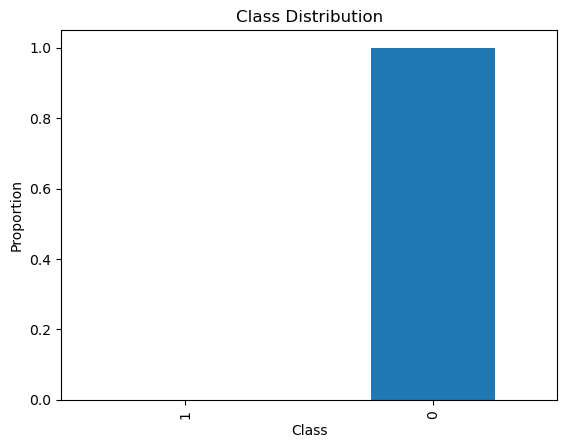

The dataset is imbalanced. The dominant class has 99.94% of the samples.
You may need to handle class imbalance before training the model.
Vectorizing features...
Balancing classes in training set with upsampling positive class...
Starting FLAML AutoML training...
Loaded model from: models:/Catalog_gowthamB2C-AutoMLModel/2
Threshold=0.50 → Precision=0.5018, Recall=1.0000, F1=0.6683, Accuracy=0.9994
ROC AUC=1.0000, PR AUC=1.0000
Top 10 prediction results (with predicted probabilities and labels):
Assigning personas based on model score and RFM segmentation...
+------------+-------------------+----------------------+------------------------+-----------+
|cluster_rank|lift_over_avg_score|avg_RFM_score         |inferred_persona        |n_customers|
+------------+-------------------+----------------------+------------------------+-----------+
|1           |2.110725418865771  |0.016840115970231672  |High Potential – VIP    |232317     |
|2           |1.8121843854652526 |-0.002809885215604041

2025/08/12 09:13:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0439d8ce2b54d19b247fe32a8b6f5d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/08/12 09:13:11 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Expected mlflow.types.schema.Datatype, mlflow.types.schema.Array, mlflow.types.schema.Object, mlflow.types.schema.Map or str for the 'type' argument, but got <class 'NoneType'>
2025/08/12 09:13:29 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('nt_call_ct', DecimalType(9,0), True), StructField('rtl_call_rec', DecimalType(9,0), True), StructField('tradearea_store', ShortType(), True), StructField('MPMAIL_IND', ShortType(), True), StructField('Post_Sales', DecimalType(38,8), True), StructField('Post_Margin', DecimalType(38,7), True), StructField('Post_Units', DecimalType(38,6), T

In [25]:
pipeline(mode='b2c')

## B2B

In [1]:
def load_b2b():
    """Load and cache the B2B Delta table."""
    df = spark.read.format("delta").load("Tables/b2b_circulation_input_15pctz").cache()
    return df

StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 3, Finished, Available, Finished)

In [2]:
def eda_and_balance(df, target_col):
    import matplotlib.pyplot as plt
    from pyspark.sql import functions as F

    print("[INFO] First 10 rows of the input DataFrame before any processing:")
    display(df.limit(10))
    print("Checking class balance in target column...")

    distribution = (
        df.groupBy(target_col)
          .agg(F.count("*").alias("count"))
          .withColumn("proportion", F.col("count") / df.count())
    )
    distribution_pd = distribution.toPandas()
    distribution_pd = distribution_pd.set_index(target_col)['proportion']
    dominant_class_proportion = distribution_pd.max()
    distribution_pd.plot(kind='bar')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.show()

    if dominant_class_proportion > 0.8:
        print(f"The dataset is imbalanced. The dominant class has {dominant_class_proportion * 100:.2f}% of the samples.")
        print("You may need to handle class imbalance before training the model.")
    else:
        print("The dataset is balanced.")
    return


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 4, Finished, Available, Finished)

In [3]:
def clean_and_split(df, target_col):
    import re
    from pyspark.sql.functions import col

    # Clean column names
    df = df.toDF(*(re.sub('[^A-Za-z0-9_]+', '_', c) for c in df.columns))
    # Drop columns that are entirely null
    non_null_columns = [c for c in df.columns if df.filter(col(c).isNotNull()).count() > 0]
    df = df.select(*non_null_columns)
    # Split into train/test
    train_raw, test_raw = df.randomSplit([0.8, 0.2], seed=42)
    return df, train_raw, test_raw


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 5, Finished, Available, Finished)

In [4]:
def preprocess_and_impute(train_raw, test_raw):
    from pyspark.ml import Pipeline as SparkPipeline

    # Place-holder pipeline (can be extended)
    pipeline_obj = SparkPipeline(stages=[])
    model = pipeline_obj.fit(train_raw)
    train_raw = model.transform(train_raw)
    test_raw = model.transform(test_raw)
    # Impute/fill missing values in all columns with 0
    train_raw = train_raw.fillna(0)
    test_raw  = test_raw.fillna(0)
    return train_raw, test_raw


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 6, Finished, Available, Finished)

In [5]:
def select_and_vectorize(df, train_raw, test_raw, target_col):
    from pyspark.sql.types import FloatType, DoubleType, ShortType, IntegerType, LongType
    from pyspark.ml.feature import VectorAssembler

    def filter_supported_columns(df, feature_cols):
        supported_types = (FloatType, DoubleType, ShortType, IntegerType, LongType)
        return [col_name for col_name in feature_cols if isinstance(df.schema[col_name].dataType, supported_types)]
    feature_cols = [c for c in df.columns if c != target_col]
    feature_cols = filter_supported_columns(df, feature_cols)
    print("Vectorizing features...")
    featurizer = VectorAssembler(
        inputCols=feature_cols, outputCol="features", handleInvalid="keep"
    )
    train_data = featurizer.transform(train_raw).select(target_col, "features")
    test_data  = featurizer.transform(test_raw).select(target_col, "features")
    return featurizer, feature_cols, train_data, test_data


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 7, Finished, Available, Finished)

In [6]:
def upsample(train_data, target_col):
    from pyspark.sql.functions import col
    print("Balancing classes in training set with upsampling positive class...")
    pos = train_data.filter(col(target_col) == 1)
    neg = train_data.filter(col(target_col) == 0)
    n_pos = pos.count()
    n_neg = neg.count()
    ratio = float(n_neg) / n_pos if n_pos > 0 else 1.0
    pos_upsampled = pos.sample(withReplacement=True, fraction=ratio, seed=42)
    train_data_bal = neg.union(pos_upsampled)
    return train_data_bal

StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 8, Finished, Available, Finished)

In [7]:
def flaml_training(train_data, test_data, target_col, mode):
    import os, flaml, mlflow
    from flaml import AutoML
    from datetime import datetime
    from flaml.automl.spark.utils import to_pandas_on_spark

    df_train = to_pandas_on_spark(train_data)
    df_test  = to_pandas_on_spark(test_data)

    os.environ["MLFLOW_TRACKING_URI"] = "file:///tmp/mlruns"
    auto_name = datetime.now().strftime(f"AutoMLExperiment_{mode}_%Y%m%d_%H%M%S")
    mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
    mlflow.set_experiment(auto_name)
    mlflow.autolog(exclusive=False)

    settings = {
        "time_budget": 120,
        "task": "binary",
        "log_file_name": f"flaml_experiment_{mode}.log",
        "eval_method": "cv",
        "n_splits": 3,
        "max_iter": 10,
        "force_cancel": True,
        "seed": 41,
        "mlflow_exp_name": auto_name,
        "verbose": 1,
        "featurization": "auto",
    }
    if flaml.__version__ > "2.3.3":
        settings["entrypoint"] = "low-code"

    automl = AutoML(**settings)
    print("Starting FLAML AutoML training...")
    with mlflow.start_run(nested=True, run_name=f"Catalog_gowtham_{mode.upper()}-AutoMLModel"):
        automl.fit(dataframe=df_train, label=target_col)
    return automl, auto_name, df_test


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 9, Finished, Available, Finished)

In [8]:
def register_and_load_model(auto_name, mode):
    import mlflow
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    exp = client.get_experiment_by_name(auto_name)
    exp_id = exp.experiment_id
    best_run = client.search_runs([exp_id], order_by=["metrics.f1_score DESC"], max_results=1)[0]
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=f"Catalog_gowtham{mode.upper()}-AutoMLModel"
    )
    print(f"Registered model '{registered_model.name}' version {registered_model.version}")
    artifact_root = client.get_run(run_id).info.artifact_uri
    spark_model_path = f"{artifact_root}/model"
    spark_model = mlflow.spark.load_model(spark_model_path)
    print("Loaded Spark model from:", spark_model_path)
    return spark_model


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 10, Finished, Available, Finished)

In [9]:
def evaluate_test_set(spark_model, df_test, target_col):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml.functions import vector_to_array
    from pyspark.sql.functions import col, when
    import pyspark.sql.functions as F

    df_test_spark = df_test.to_spark()
    scored_test = spark_model.transform(df_test_spark)\
        .withColumn("pred_prob", vector_to_array(col("probability"))[1])
    preds = scored_test.withColumn("pred", when(col("pred_prob") >= 0.5, 1).otherwise(0))
    metrics = preds.agg(
        F.sum(when((col(target_col) == 1) & (col("pred") == 1), 1).otherwise(0)).alias("tp"),
        F.sum(when((col(target_col) == 0) & (col("pred") == 1), 1).otherwise(0)).alias("fp"),
        F.sum(when((col(target_col) == 1) & (col("pred") == 0), 1).otherwise(0)).alias("fn"),
        F.sum(when((col(target_col) == 0) & (col("pred") == 0), 1).otherwise(0)).alias("tn")
    ).collect()[0]
    tp, fp, fn, tn = metrics["tp"], metrics["fp"], metrics["fn"], metrics["tn"]
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall   = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1       = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn)>0 else 0.0
    roc_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol=target_col, metricName="areaUnderROC")
    pr_eval  = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol=target_col, metricName="areaUnderPR")
    roc_auc  = roc_eval.evaluate(scored_test)
    pr_auc   = pr_eval.evaluate(scored_test)
    print(f"Threshold=0.50 → Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Accuracy={accuracy:.4f}")
    print(f"ROC AUC={roc_auc:.4f}, PR AUC={pr_auc:.4f}")
    print("Top 10 prediction results (with predicted probabilities and labels):")
    preds.select("pred_prob", "pred").show(10, False)
    return spark_model


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 11, Finished, Available, Finished)

In [11]:
def post_scoring_and_segments(df, featurizer, spark_model, target_col, mode):
    import math
    from pyspark.sql.window import Window
    from pyspark.sql.functions import col, when, round
    import pyspark.sql.functions as F
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.functions import vector_to_array
    from pyspark.sql.types import DoubleType

    print("Scoring customers and joining RFM metrics...")

    # 1. Featurize input data
    df_features = featurizer.transform(df)

    # 2. Score the customers
    scored_df = spark_model.transform(df_features) \
        .withColumn("propensity", vector_to_array(col("probability"))[1]) \
        .select("Cust_ID", "propensity", target_col)

    # 3. Bring in RFM score
    rfm_df = df.select("Cust_ID", "RFM_Z_Composite").distinct()
    scored_df = scored_df.join(rfm_df, on="Cust_ID", how="left")

    print("Assigning deciles for propensity and RFM scores...")
    window_propensity = Window.orderBy(col("propensity").desc())
    window_rfm = Window.orderBy(col("RFM_Z_Composite").desc())
    scored_df = scored_df \
        .withColumn("propensity_decile", F.ntile(10).over(window_propensity)) \
        .withColumn("rfm_decile", F.ntile(10).over(window_rfm))

    # 4. Composite score calculation
    propensity_weight = 0.6
    rfm_weight = 0.4
    propensity_power = 1.5
    rfm_power = 1.2
    scored_df = scored_df.withColumn(
        "final_score_nuanced",
        (F.pow(11 - F.col("propensity_decile"), propensity_power) * propensity_weight) +
        (F.pow(11 - F.col("rfm_decile"), rfm_power) * rfm_weight)
    )

    # 5. Decile based on final score
    window_decile = Window.orderBy(col("final_score_nuanced").desc())
    scored_df = scored_df.withColumn("decile", F.ntile(10).over(window_decile))

    # 6. Fix types and fill nulls
    scored_df = scored_df.withColumn("propensity", F.col("propensity").cast(DoubleType())) \
        .withColumn("RFM_Z_Composite", F.col("RFM_Z_Composite").cast(DoubleType()))
    scored_df = scored_df.fillna({"propensity": 0.0, "RFM_Z_Composite": 0.0})

    # 7. KMeans clustering
    assembler = VectorAssembler(inputCols=["final_score_nuanced"], outputCol="features")
    scored_features = assembler.transform(scored_df)
    print("Segmenting customers using KMeans clustering...")
    kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=10, seed=42).fit(scored_features)
    clustered_df = kmeans.transform(scored_features)

    # 8. Rank clusters
    cluster_ranking = clustered_df.groupBy("cluster").agg(
        F.avg("final_score_nuanced").alias("avg_score")
    ).withColumn(
        "cluster_rank", F.ntile(10).over(Window.orderBy(F.col("avg_score").desc()))
    )
    final_clustered_df = clustered_df.join(cluster_ranking, on="cluster", how="left").drop("features")

    print("Assigning personas based on model score and RFM segmentation...")

    # 9. Compute stats for lift normalization
    overall_stats = final_clustered_df.agg(
        F.avg("final_score_nuanced").alias("overall_avg_score"),
        F.avg(target_col).alias("overall_event_rate")
    ).collect()[0]
    overall_avg_score = overall_stats["overall_avg_score"]
    overall_event_rate = overall_stats["overall_event_rate"]

    # 10. Build cluster summary
    cluster_summary = final_clustered_df.groupBy("cluster_rank").agg(
        F.avg("final_score_nuanced").alias("avg_final_score"),
        F.avg("propensity").alias("avg_propensity"),
        F.avg("RFM_Z_Composite").alias("avg_RFM_score"),
        F.count("*").alias("n_customers"),
        F.avg(target_col).alias("event_rate"),
        F.sum(target_col).alias("total_events")
    ).withColumn(
        "lift_over_avg_score", F.col("avg_final_score") / F.lit(overall_avg_score)
    ).withColumn(
        "lift_over_avg_event_rate",
        F.when(F.lit(overall_event_rate) > 0, F.col("event_rate") / F.lit(overall_event_rate)).otherwise(F.lit(None))
    ).orderBy("cluster_rank")

    # 11. Persona assignment (as per your image logic)
    cluster_summary = cluster_summary.withColumn(
        "inferred_persona",
        when((col("lift_over_avg_score") >= 1.6) & (col("avg_RFM_score") > 0), "High Potential – VIP")
        .when((col("lift_over_avg_score") >= 1.5) & (col("avg_RFM_score") <= 0), "High Potential – Low RFM")
        .when((col("lift_over_avg_score") >= 1.0), "Moderate Potential")
        .when((col("lift_over_avg_score") < 1.0) & (col("avg_RFM_score") < 0), "Loyal – Low Intent")
        .otherwise("Nurture")
    )

    # 12. Preview persona summary (cluster based)
    cluster_summary.select(
        "cluster_rank", "lift_over_avg_score", "avg_RFM_score", "inferred_persona", "n_customers"
    ).orderBy("cluster_rank").show(truncate=False)

    # 13. Join persona back to customers
    final_clustered_df = final_clustered_df.join(
        cluster_summary.select("cluster_rank", "inferred_persona", "lift_over_avg_score"),
        on="cluster_rank",
        how="left"
    )
    final_clustered_df = final_clustered_df.withColumnRenamed("inferred_persona", "persona")

    # 14. Persona summary with count (for output table like your image)
    persona_lift_df = final_clustered_df.groupBy("persona").agg(
        round(F.avg("lift_over_avg_score"), 2).alias("Avg_Lift_Overall"),
        F.count("*").alias("Customer_Count")
    ).orderBy("Avg_Lift_Overall", ascending=False)
    # This is the FINAL SUMMARY table you want to see:
    persona_lift_df.show(truncate=False)

    print("Cluster summary statistics:")
    cluster_summary.show(truncate=False)

    # 15. Two-group summary based on event-rate lift median
    median_val = cluster_summary.approxQuantile("lift_over_avg_event_rate", [0.5], 0.0)[0]
    cluster_summary = cluster_summary.withColumn(
        "event_rate_group",
        F.when(F.col("lift_over_avg_event_rate") > median_val, "Above Median Event Rate")
         .otherwise("Below Median Event Rate")
    )

    print("Two-group summary statistics:")
    two_group_summary = cluster_summary.groupBy("event_rate_group").agg(
        F.avg("avg_final_score").alias("avg_final_score"),
        F.avg("avg_propensity").alias("avg_propensity"),
        F.avg("avg_RFM_score").alias("avg_RFM_score"),
        F.sum("n_customers").alias("n_customers"),
        F.avg("event_rate").alias("avg_event_rate"),
        F.sum("total_events").alias("total_events")
    ).orderBy(F.col("avg_event_rate").desc())
    two_group_summary.show(truncate=False)

    # 16. Save with clusters
    scored_df_with_clusters = scored_df.join(
        final_clustered_df.select("Cust_ID", "cluster", "cluster_rank"),
        on="Cust_ID", how="left"
    )
    save_table = f"Intern_LH.Catalog_{mode.upper()}_Customer_Scored_WithClusters"
    scored_df_with_clusters.write.mode("overwrite").format("delta").saveAsTable(save_table)
    print(f"Saved with clusters to: {save_table}")

    # 17. HOLDOUT plan
    print("Calculating holdout test/control groups per cluster...")
    confidence_z = 1.96
    power_z = 0.84
    min_detectable_lift = 0.002

    cluster_stats = cluster_summary.select(
        "cluster_rank", "n_customers", "event_rate"
    ).collect()

    holdout_plan = []
    for row in cluster_stats:
        p = row["event_rate"]
        n_customers = row["n_customers"]
        if p == 0:
            holdout_size = max(500, int(n_customers * 0.05))
        else:
            numerator = (confidence_z + power_z) ** 2 * (p * (1 - p)) * 2
            denominator = (min_detectable_lift ** 2)
            needed_n = numerator / denominator
            holdout_size = min(n_customers, math.ceil(needed_n))
        holdout_pct = holdout_size / n_customers
        holdout_plan.append((row["cluster_rank"], n_customers, p, holdout_size, holdout_pct))

    holdout_df = df.sparkSession.createDataFrame(
        holdout_plan,
        ["cluster_rank", "n_customers", "event_rate", "holdout_size", "holdout_pct"]
    )
    holdout_df.show(truncate=False)

    print("Assigning customers to mail/holdout per cluster...")
    mail_with_holdout = scored_df_with_clusters.withColumn("rand", F.rand(seed=42))
    mail_with_holdout = mail_with_holdout.join(
        holdout_df.select("cluster_rank", "holdout_pct"), on="cluster_rank", how="left"
    )
    mail_with_holdout = mail_with_holdout.withColumn(
        "holdout_flag",
        F.when(F.col("rand") < F.col("holdout_pct"), 1).otherwise(0)
    )
    save_table_holdout = f"Intern_LH.Catalog_{mode.upper()}_Customer_Scored_WithClusters_Holdout"
    mail_with_holdout.write.mode("overwrite").format("delta").saveAsTable(save_table_holdout)
    print(f"Saved with clusters & holdout to: {save_table_holdout}")


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 13, Finished, Available, Finished)

In [12]:
def pipeline(mode="b2b"):
    # Parameters
    target_col = "response_flag"

    # Load, inspect, clean, split
    df = load_b2b()
    eda_and_balance(df, target_col)
    df, train_raw, test_raw = clean_and_split(df, target_col)
    train_raw, test_raw     = preprocess_and_impute(train_raw, test_raw)

    # Featurize, upsample, train
    featurizer, feature_cols, train_data, test_data = select_and_vectorize(df, train_raw, test_raw, target_col)
    train_data      = upsample(train_data, target_col)
    automl, exp_id, df_test = flaml_training(train_data, test_data, target_col, mode)
    spark_model     = register_and_load_model(exp_id, mode)

    # Evaluate and full post-processing pipeline: scoring, segmentation, RFM, personas, save, holdout
    evaluate_test_set(spark_model, df_test, target_col)
    post_scoring_and_segments(df, featurizer, spark_model, target_col, mode)


StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 14, Finished, Available, Finished)

StatementMeta(, 1641d255-bca6-434e-a54d-d1f402c15965, 15, Submitted, Running, Running)

[INFO] First 10 rows of the input DataFrame before any processing:


SynapseWidget(Synapse.DataFrame, 3c5ccca1-9f35-4159-945d-8142a0c5a43e)

Checking class balance in target column...


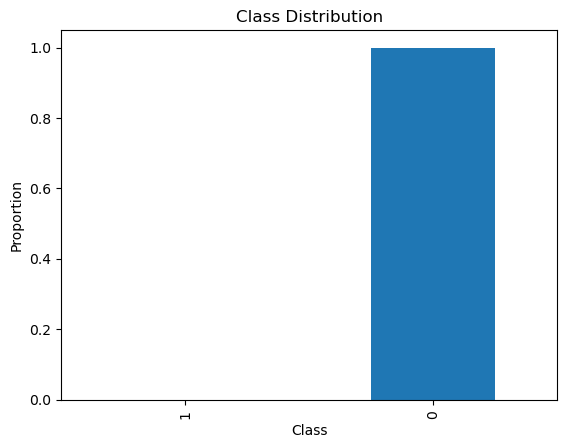

The dataset is imbalanced. The dominant class has 99.90% of the samples.
You may need to handle class imbalance before training the model.


Vectorizing features...
Balancing classes in training set with upsampling positive class...

Loaded Spark model from: file:///tmp/mlruns/113327645316278779/aa3d3373dba34dc08ec7cca550c56dbd/artifacts/model
Assigning personas based on model score and RFM segmentation...
+------------+-------------------+---------------------+------------------------+-----------+
|cluster_rank|lift_over_avg_score|avg_RFM_score        |inferred_persona        |n_customers|
+------------+-------------------+---------------------+------------------------+-----------+
|1           |2.094411485141001  |-0.007099790449779077|High Potential – Low RFM|42877      |
|2           |1.88715942507059   |-0.030057405923648566|High Potential – Low RFM|8000       |
|3           |1.7789180722781055 |7.182914473664276E-4 |High Potential – VIP    |39184      |
|4           |1.5147660502784648 |-0.015137384148182935|High Potential – Low RFM|42958      |
|5           |1.1913951987762148 |-0.01806533211082552 |Moderate Potentia

2025/08/11 08:33:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpakn3bnxk/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025/08/11 08:33:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpeivp1kxb/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025/08/11 08:33:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjdfso72y/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025/08/11 08:34:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpioekq7br/model, flavor: 

In [13]:
pipeline(mode='b2b')